## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
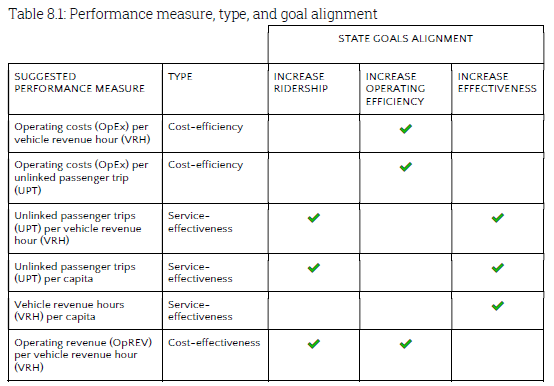

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from new_transit_metrics_utils import GCS_FILE_PATH, make_long, sum_by_group

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

In [3]:
df.columns

Index(['agency_name', 'agency_status', 'city', 'mode', 'service', 'ntd_id',
       'reporter_type', 'reporting_module', 'state', 'primary_uza_name',
       'year', 'upt', 'vrh', 'vrm', 'opexp_total', 'RTPA', '_merge'],
      dtype='object')

In [4]:
df_agg = (
    df.groupby(["ntd_id", "city", "agency_name", "mode", "service"])
    .agg({"upt": "sum", "vrh": "sum", "vrm": "sum", "opexp_total": "sum"})
    .reset_index()
)

In [5]:
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
}

for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (df_agg[num] / df_agg[dem]).round(2)

# Dealing with NaN and inf values
Some of the metric calculation results in either inf or NaN values due to divide-by-zero scenarios. These values break the standard devatition calculation.

We will analyze the differences in standard deviation by filtering the data by these scenarios
1. remove rows with zeros
2. 
    1. upt_per_vrh/vrm NaN (0/0) values replaced with zero. Zero riders per revenue mile/hours still make sense. buses can still run and pick up zero passengers. highlights service ineffencies 
    2. opex_per_upt/vrm/vrh inf (#/0) values replaced with its opexp value. operating cost still exist even if nobody rides the bus. highlights cost inefficienies 
    3. opex_per_upt/vrm/vrh NaN (0/0) values replaced with zeros. not running the bus results in not picking up passengers and  zero operating cost.

In [6]:
# any rows with zero upt/vrh/vrm/opex?
no_zero_rows = df_agg[
    (df_agg["upt"] != 0)
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]

In [7]:
replaced_values = df_agg.fillna(0)

# applying logic to alternate dataframe
col_list = ["opex_per_vrh", "opex_per_vrm", "opex_per_upt"]

for i in col_list:
    replaced_values[i] = replaced_values.apply(
        lambda row: row["opexp_total"] if row[i] == np.inf else row[i], axis=1
    )

In [8]:
display(len(df_agg), len(no_zero_rows), len(replaced_values))

412

401

412

In [9]:
no_zero_rows.head()

,ntd_id,city,agency_name,mode,service,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
2,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,444622064,13166018,435132944,3978263763,302.16,9.14,33.77,1.02,8.95
3,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,Directly Operated,7104589,198797,5840831,81439438,409.66,13.94,35.74,1.22,11.46
4,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,3369844,116589,1839575,47048789,403.54,25.58,28.90,1.83,13.96
5,90004,Bakersfield,Golden Empire Transit District (GET),Bus,Directly Operated,26828371,1581266,19970743,168768565,106.73,8.45,16.97,1.34,6.29
6,90004,Bakersfield,Golden Empire Transit District (GET),Demand Response,Directly Operated,541009,290456,4238988,25127093,86.51,5.93,1.86,0.13,46.44


In [10]:
no_zero_rows_melt = pd.melt(
    no_zero_rows,
    id_vars=["ntd_id", "city", "agency_name", "mode", "service"],
    value_vars=[
        "opex_per_vrh",
        "opex_per_vrm",
        "upt_per_vrh",
        "upt_per_vrm",
        "opex_per_upt",
    ],
    var_name="performance_metrics",
    value_name="metric_units",
)

no_zero_rows_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005 entries, 0 to 2004
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ntd_id               2005 non-null   object 
 1   city                 2005 non-null   object 
 2   agency_name          2005 non-null   object 
 3   mode                 2005 non-null   object 
 4   service              2005 non-null   object 
 5   performance_metrics  2005 non-null   object 
 6   metric_units         2005 non-null   float64
dtypes: float64(1), object(6)
memory usage: 109.8+ KB


In [11]:
no_zero_rows_melt["performance_metrics"].value_counts()

opex_per_vrh    401
opex_per_vrm    401
upt_per_vrh     401
upt_per_vrm     401
opex_per_upt    401
Name: performance_metrics, dtype: int64

## Overall Summary Statistics

In [12]:
display(no_zero_rows.columns, no_zero_rows.describe(), no_zero_rows_melt.describe())

Index(['ntd_id', 'city', 'agency_name', 'mode', 'service', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,4.010000e+02,4.010000e+02,4.010000e+02,4.010000e+02,401.000000,401.000000,401.000000,401.000000,401.000000
mean,1.387393e+07,6.057536e+05,9.150192e+06,1.159269e+08,152.473890,11.755387,9.795536,0.785162,29.377781
std,7.571695e+07,2.197522e+06,3.244346e+07,4.824113e+08,205.996039,20.775520,13.854108,1.527742,24.157545
min,3.000000e+01,9.000000e+00,2.810000e+02,2.590000e+02,21.930000,0.520000,0.620000,0.050000,1.860000
25%,9.960300e+04,2.597900e+04,3.275160e+05,2.757428e+06,83.280000,5.960000,2.610000,0.180000,10.290000
50%,3.538580e+05,8.076900e+04,1.208917e+06,8.105467e+06,116.130000,8.580000,5.380000,0.370000,20.540000
75%,2.716278e+06,3.188760e+05,5.037198e+06,4.053515e+07,150.660000,12.000000,11.210000,0.780000,44.770000
max,1.249836e+09,3.490394e+07,4.351329e+08,6.949403e+09,2740.980000,327.640000,122.010000,18.510000,119.070000


,metric_units
count,2005.000000
mean,40.837551
std,109.153372
min,0.050000
25%,2.490000
50%,9.610000
75%,44.410000
max,2740.980000


In [13]:
# all metrics dict

all_metrics_x = {
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

all_metrics = [
    "upt_per_vrh",
    "upt_per_vrm",
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

service_metrics_list = [
    "upt_per_vrh",
    "upt_per_vrm",
]

cost_metrics_list = [
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

In [53]:
def metrics_charts(metrics_list, df):
    for i in metrics_list:
        #
        box_plot = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_boxplot(extent="min-max")
            .encode(y="mode:N", x="metric_units:Q")
            .properties(
                title=f"{i} Boxplot",
                width="container",  # smaller width per facet
                height=300,
            )
        )

        # ,

        # bar chart
        bar_chart = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_bar()
            .encode(
                x=alt.X("agency_name:N", sort="-y"),
                y="metric_units",
                color="service",
                tooltip=[
                    "agency_name:N", 
                    "mode", 
                    "service", 
                    "metric_units"
                ],
            )
            .properties(
                
                width=400,  # smaller width per facet
                height=200,
            )
            .facet("mode:N", columns=3, title=f"Barchart For All {i}")
            .resolve_scale(x="independent", y="independent")
            .interactive()
        )

        #
        # distribution plot
        histogram = (
            alt.Chart(df[df["performance_metrics"] == i])
            .mark_bar()
            .encode(
                alt.X("metric_units", bin=alt.Bin(step=5)),
                y="count()",
                tooltip=["count()"],
                # row="mode"
            )
            .properties(
                title=f"{i} Distribution",
                width=500,  # smaller width per facet
                height=200,
            )
            .facet("mode:N", columns=3)
            .resolve_scale(x="independent", y="independent")
        )

        # f"Heatmap Chart for {i}",
        # # heatmap
        # alt.Chart(df[df["performance_metrics"]==i])
        #     .mark_rect()
        #     .encode(
        #         y="agency_name",
        #         x="service",
        #         color="metric_units",
        #         tooltip= ["metric_units","service","agency_name"],
        #         # row= "mode",
        #     ).properties(
        #         title = f"{i} Heatmap"
        #     ).facet("mode:N",columns=6
        #     ).interactive(),

        display(
            f"Box plot for {i}",
            box_plot,
            f"Statewide Bar Chart for {i}",
            bar_chart,
            f"Histogram Chart for {i}",
            histogram,
        )
        print("")

## Statewide Service-Effectiveness Metrics

### Unlinked Passenger Trips per Vehicle Revenue Hours (upt_per_vrh)

In [54]:
metrics_charts(metrics_list=["upt_per_vrh"], df=no_zero_rows_melt)

'Box plot for upt_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for upt_per_vrh'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrh'

alt.FacetChart(...)

### upt_per_vrm

In [46]:
metrics_charts(metrics_list=["upt_per_vrm"], df=no_zero_rows_melt)

'Box plot for upt_per_vrm'

alt.Chart(...)

'Statewide Bar Chart for upt_per_vrm'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrm'

alt.FacetChart(...)

## Statewide Cost-Effecticeness Metrics

## opex_per_vrh

In [55]:
metrics_charts(["opex_per_vrh"], df=no_zero_rows_melt)

'Box plot for opex_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for opex_per_vrh'

alt.FacetChart(...)

'Histogram Chart for opex_per_vrh'

alt.FacetChart(...)

## opex_per_vrm

In [56]:
metrics_charts(["opex_per_vrm"], df=no_zero_rows_melt)

'Box plot for opex_per_vrm'

alt.Chart(...)

'Statewide Bar Chart for opex_per_vrm'

alt.FacetChart(...)

'Histogram Chart for opex_per_vrm'

alt.FacetChart(...)

## opex_per_upt

In [51]:
metrics_charts(["opex_per_upt"], df=no_zero_rows_melt)

'Box plot for opex_per_upt'

alt.Chart(...)

'Statewide Bar Chart for opex_per_upt'

alt.FacetChart(...)

'Histogram Chart for opex_per_upt'

alt.FacetChart(...)

## Alt method to calculate bottom 5%

all_metrics =[
    "upt_per_vrh",
    "upt_per_vrm",
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

service_metrics_list = [
    "upt_per_vrh",
    "upt_per_vrm",
]

cost_metrics_list = [
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

In [17]:
display(
    no_zero_rows_melt.head(), no_zero_rows.head(), no_zero_rows_melt["mode"].unique()
)

,ntd_id,city,agency_name,mode,service,performance_metrics,metric_units
0,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,opex_per_vrh,302.16
1,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,Directly Operated,opex_per_vrh,409.66
2,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,opex_per_vrh,403.54
3,90004,Bakersfield,Golden Empire Transit District (GET),Bus,Directly Operated,opex_per_vrh,106.73
4,90004,Bakersfield,Golden Empire Transit District (GET),Demand Response,Directly Operated,opex_per_vrh,86.51


,ntd_id,city,agency_name,mode,service,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
2,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,444622064,13166018,435132944,3978263763,302.16,9.14,33.77,1.02,8.95
3,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,Directly Operated,7104589,198797,5840831,81439438,409.66,13.94,35.74,1.22,11.46
4,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,3369844,116589,1839575,47048789,403.54,25.58,28.90,1.83,13.96
5,90004,Bakersfield,Golden Empire Transit District (GET),Bus,Directly Operated,26828371,1581266,19970743,168768565,106.73,8.45,16.97,1.34,6.29
6,90004,Bakersfield,Golden Empire Transit District (GET),Demand Response,Directly Operated,541009,290456,4238988,25127093,86.51,5.93,1.86,0.13,46.44


array(['Heavy Rail', 'Hybrid Rail', 'Monorail / Automated Guideway',
       'Bus', 'Demand Response', 'Commuter Bus', 'Demand Response Taxi',
       'Light Rail', 'Bus Rapid Transit', 'Cable Car', 'Streetcar',
       'Trolleybus', 'Ferryboats', 'Commuter Rail', 'Vanpool'],
      dtype=object)

In [18]:
all_modes = no_zero_rows_melt["mode"].unique().tolist()

In [19]:
# Who are the bottom 5% of `upt_per_vrh`
cutoff = no_zero_rows["upt_per_vrh"].quantile(0.05)
print(cutoff)

bottom_5 = no_zero_rows[no_zero_rows["upt_per_vrh"] <= cutoff]
print(bottom_5["agency_name"].nunique())

1.56
21


In [20]:
# Who are the bottom 5% of each service_metrics
for metric_name in service_metrics_list:
    cutoff = no_zero_rows[metric_name].quantile(0.05)
    bottom = no_zero_rows[no_zero_rows[metric_name] <= cutoff]
    display(
        f"bottom {metric_name}",
        print(bottom["agency_name"].nunique()),
        bottom[["agency_name", "mode", "service", metric_name]].sort_values(
            by=metric_name, ascending=True
        ),
    )

21


'bottom upt_per_vrh'

None

,agency_name,mode,service,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Demand Response,Purchased Transportation,0.62
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,1.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,1.11
170,Livermore / Amador Valley Transit Authority (L...,Demand Response,Purchased Transportation,1.32
309,City of Carson - Transportation Services Division,Bus,Directly Operated,1.32
202,City of Union City (UCT) - Public Works,Demand Response,Purchased Transportation,1.33
374,City of West Hollywood (WEHO) - Business Devel...,Demand Response,Purchased Transportation,1.36
365,City of Rosemead - Public Works,Demand Response,Purchased Transportation,1.37
297,City of Bell - Community Services Department,Demand Response,Purchased Transportation,1.37
267,"Paratransit, Inc.",Demand Response,Purchased Transportation,1.37


29


'bottom upt_per_vrm'

None

,agency_name,mode,service,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,0.05
400,City of Escalon - Transit Services,Bus,Purchased Transportation,0.05
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,Purchased Transportation,0.07
96,Riverside Transit Agency (RTA),Demand Response Taxi,Purchased Transportation,0.07
272,Imperial County Transportation Commission (ICTC),Demand Response,Purchased Transportation,0.08
151,City of Visalia (VT) - Transportation,Commuter Bus,Purchased Transportation,0.08
95,Riverside Transit Agency (RTA),Demand Response,Purchased Transportation - Taxi,0.08
149,Yolo County Transportation District (YCTD),Demand Response,Purchased Transportation,0.08
139,SunLine Transit Agency,Vanpool,Purchased Transportation,0.08
228,County of Placer (PCT/TART) - Department of Pu...,Bus,Purchased Transportation,0.09


In [21]:
# Who are the bottom 5% of each performance metrics
for metric_name in all_metrics:
    print(f"bottom {metric_name}"),
    print(bottom["agency_name"].nunique()),
    if metric_name in service_metrics_list:
        service_cutoff = no_zero_rows[metric_name].quantile(0.05)
        service_bottom = no_zero_rows[no_zero_rows[metric_name] <= service_cutoff][
            ["agency_name", "mode", "service", metric_name]
        ]
        display(service_bottom.sort_values(by=metric_name, ascending=True))

    elif metric_name in cost_metrics_list:
        cost_cutoff = no_zero_rows[metric_name].quantile(0.95)
        cost_bottom = no_zero_rows[no_zero_rows[metric_name] >= cost_cutoff][
            ["agency_name", "mode", "service", metric_name]
        ]
        display(cost_bottom.sort_values(by=metric_name, ascending=False))

bottom upt_per_vrh
29


,agency_name,mode,service,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Demand Response,Purchased Transportation,0.62
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,1.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,1.11
170,Livermore / Amador Valley Transit Authority (L...,Demand Response,Purchased Transportation,1.32
309,City of Carson - Transportation Services Division,Bus,Directly Operated,1.32
202,City of Union City (UCT) - Public Works,Demand Response,Purchased Transportation,1.33
374,City of West Hollywood (WEHO) - Business Devel...,Demand Response,Purchased Transportation,1.36
365,City of Rosemead - Public Works,Demand Response,Purchased Transportation,1.37
297,City of Bell - Community Services Department,Demand Response,Purchased Transportation,1.37
267,"Paratransit, Inc.",Demand Response,Purchased Transportation,1.37


bottom upt_per_vrm
29


,agency_name,mode,service,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,0.05
400,City of Escalon - Transit Services,Bus,Purchased Transportation,0.05
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,Purchased Transportation,0.07
96,Riverside Transit Agency (RTA),Demand Response Taxi,Purchased Transportation,0.07
272,Imperial County Transportation Commission (ICTC),Demand Response,Purchased Transportation,0.08
151,City of Visalia (VT) - Transportation,Commuter Bus,Purchased Transportation,0.08
95,Riverside Transit Agency (RTA),Demand Response,Purchased Transportation - Taxi,0.08
149,Yolo County Transportation District (YCTD),Demand Response,Purchased Transportation,0.08
139,SunLine Transit Agency,Vanpool,Purchased Transportation,0.08
228,County of Placer (PCT/TART) - Department of Pu...,Bus,Purchased Transportation,0.09


bottom opex_per_vrh
29


,agency_name,mode,service,opex_per_vrh
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,2740.98
270,San Francisco Bay Area Water Emergency Transpo...,Ferryboats,Purchased Transportation,2145.69
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,1048.84
225,Altamont Corridor Express (ACE),Commuter Rail,Purchased Transportation,1015.05
383,Sonoma-Marin Area Rail Transit District (SMART),Commuter Rail,Directly Operated,924.74
184,Southern California Regional Rail Authority (S...,Commuter Rail,Purchased Transportation,739.19
85,North County Transit District (NCTD),Commuter Rail,Directly Operated,703.64
89,North County Transit District (NCTD),Hybrid Rail,Purchased Transportation,701.78
167,Peninsula Corridor Joint Powers Board (PCJPB),Commuter Rail,Purchased Transportation,689.42
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,676.42


bottom opex_per_vrm
29


,agency_name,mode,service,opex_per_vrm
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,327.64
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,206.07
270,San Francisco Bay Area Water Emergency Transpo...,Ferryboats,Purchased Transportation,105.29
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,91.20
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,47.66
50,City and County of San Francisco (SFMTA) - Tra...,Light Rail,Directly Operated,46.57
40,Santa Clara Valley Transportation Authority (VTA),Light Rail,Directly Operated,42.20
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,40.12
383,Sonoma-Marin Area Rail Transit District (SMART),Commuter Rail,Directly Operated,35.76
89,North County Transit District (NCTD),Hybrid Rail,Purchased Transportation,31.98


bottom opex_per_upt
29


,agency_name,mode,service,opex_per_upt
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,119.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,111.53
30,San Joaquin Regional Transit District (RTD),Demand Response,Directly Operated,106.91
118,City of Commerce (CCT) - Transportation,Demand Response,Directly Operated,99.16
352,City of Malibu - Community Services Department,Demand Response,Purchased Transportation,96.60
363,City of Pico Rivera - Transit Division/Parks a...,Demand Response,Purchased Transportation,96.55
309,City of Carson - Transportation Services Division,Bus,Directly Operated,95.41
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,94.66
247,City of Elk Grove(etran),Demand Response,Purchased Transportation,91.47
249,San Luis Obispo Regional Transit Authority (SL...,Demand Response,Directly Operated,88.72


In [22]:
# Who are the bottom 5% of each performance metrics, BY MODE
for metric_name in all_metrics:
    for mode in all_modes:
        if metric_name in service_metrics_list:
            service_cutoff = no_zero_rows[no_zero_rows["mode"] == mode][
                metric_name
            ].quantile(0.05)
            service_bottom = no_zero_rows[
                (no_zero_rows["mode"] == mode)
                & (no_zero_rows[metric_name] <= service_cutoff)
            ][["agency_name", "mode", "service", metric_name]]
            display(
                f"Bottom {metric_name} for {mode}",
                service_bottom.sort_values(by=metric_name, ascending=True),
            )

        elif metric_name in cost_metrics_list:
            cost_cutoff = no_zero_rows[no_zero_rows["mode"] == mode][
                metric_name
            ].quantile(0.95)
            cost_bottom = no_zero_rows[
                (no_zero_rows["mode"] == mode)
                & (no_zero_rows[metric_name] >= cost_cutoff)
            ][["agency_name", "mode", "service", metric_name]]
            display(
                f"Bottom {metric_name} for {mode}",
                cost_bottom.sort_values(by=metric_name, ascending=False),
            )

'Bottom upt_per_vrh for Heavy Rail'

,agency_name,mode,service,upt_per_vrh
2,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,33.77


'Bottom upt_per_vrh for Hybrid Rail'

,agency_name,mode,service,upt_per_vrh
3,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,Directly Operated,35.74


'Bottom upt_per_vrh for Monorail / Automated Guideway'

,agency_name,mode,service,upt_per_vrh
4,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,28.9


'Bottom upt_per_vrh for Bus'

,agency_name,mode,service,upt_per_vrh
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,1.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,1.11
309,City of Carson - Transportation Services Division,Bus,Directly Operated,1.32
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,1.42
228,County of Placer (PCT/TART) - Department of Pu...,Bus,Purchased Transportation,1.43
57,City of Santa Rosa - Transit Division,Bus,Purchased Transportation,2.30
119,City of Arcadia - Development Services Departm...,Bus,Purchased Transportation,2.35
371,City of West Covina - Public Services Department,Bus,Purchased Transportation,2.78


'Bottom upt_per_vrh for Demand Response'

,agency_name,mode,service,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Demand Response,Purchased Transportation,0.62
170,Livermore / Amador Valley Transit Authority (L...,Demand Response,Purchased Transportation,1.32
202,City of Union City (UCT) - Public Works,Demand Response,Purchased Transportation,1.33
374,City of West Hollywood (WEHO) - Business Devel...,Demand Response,Purchased Transportation,1.36
267,"Paratransit, Inc.",Demand Response,Purchased Transportation,1.37
297,City of Bell - Community Services Department,Demand Response,Purchased Transportation,1.37
365,City of Rosemead - Public Works,Demand Response,Purchased Transportation,1.37
118,City of Commerce (CCT) - Transportation,Demand Response,Directly Operated,1.38
149,Yolo County Transportation District (YCTD),Demand Response,Purchased Transportation,1.38


'Bottom upt_per_vrh for Commuter Bus'

,agency_name,mode,service,upt_per_vrh
395,Madera County - Public Works Department,Commuter Bus,Purchased Transportation,2.64
130,Monterey-Salinas Transit (MST),Commuter Bus,Directly Operated,3.17


'Bottom upt_per_vrh for Demand Response Taxi'

,agency_name,mode,service,upt_per_vrh
38,Santa Clara Valley Transportation Authority (VTA),Demand Response Taxi,Purchased Transportation,1.79
96,Riverside Transit Agency (RTA),Demand Response Taxi,Purchased Transportation,1.81


'Bottom upt_per_vrh for Light Rail'

,agency_name,mode,service,upt_per_vrh
40,Santa Clara Valley Transportation Authority (VTA),Light Rail,Directly Operated,26.5


'Bottom upt_per_vrh for Bus Rapid Transit'

,agency_name,mode,service,upt_per_vrh
43,Alameda-Contra Costa Transit District,Bus Rapid Transit,Directly Operated,43.67


'Bottom upt_per_vrh for Cable Car'

,agency_name,mode,service,upt_per_vrh
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,38.22


'Bottom upt_per_vrh for Streetcar'

,agency_name,mode,service,upt_per_vrh
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,69.1


'Bottom upt_per_vrh for Trolleybus'

,agency_name,mode,service,upt_per_vrh
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,50.4


'Bottom upt_per_vrh for Ferryboats'

,agency_name,mode,service,upt_per_vrh
270,San Francisco Bay Area Water Emergency Transpo...,Ferryboats,Purchased Transportation,104.27


'Bottom upt_per_vrh for Commuter Rail'

,agency_name,mode,service,upt_per_vrh
85,North County Transit District (NCTD),Commuter Rail,Directly Operated,15.84


'Bottom upt_per_vrh for Vanpool'

,agency_name,mode,service,upt_per_vrh
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,Purchased Transportation,3.53


'Bottom upt_per_vrm for Heavy Rail'

,agency_name,mode,service,upt_per_vrm
2,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,1.02


'Bottom upt_per_vrm for Hybrid Rail'

,agency_name,mode,service,upt_per_vrm
3,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,Directly Operated,1.22


'Bottom upt_per_vrm for Monorail / Automated Guideway'

,agency_name,mode,service,upt_per_vrm
4,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,1.83


'Bottom upt_per_vrm for Bus'

,agency_name,mode,service,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,0.05
400,City of Escalon - Transit Services,Bus,Purchased Transportation,0.05
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,0.09
228,County of Placer (PCT/TART) - Department of Pu...,Bus,Purchased Transportation,0.09
398,Kern Regional Transit (KT),Bus,Purchased Transportation,0.12
309,City of Carson - Transportation Services Division,Bus,Directly Operated,0.14
371,City of West Covina - Public Services Department,Bus,Purchased Transportation,0.20
119,City of Arcadia - Development Services Departm...,Bus,Purchased Transportation,0.21


'Bottom upt_per_vrm for Demand Response'

,agency_name,mode,service,upt_per_vrm
95,Riverside Transit Agency (RTA),Demand Response,Purchased Transportation - Taxi,0.08
149,Yolo County Transportation District (YCTD),Demand Response,Purchased Transportation,0.08
272,Imperial County Transportation Commission (ICTC),Demand Response,Purchased Transportation,0.08
21,San Mateo County Transit District (SMCTD),Demand Response,Purchased Transportation - Taxi,0.09
30,San Joaquin Regional Transit District (RTD),Demand Response,Directly Operated,0.09
36,Santa Clara Valley Transportation Authority (VTA),Demand Response,Purchased Transportation,0.09
54,"Golden Gate Bridge, Highway and Transportation...",Demand Response,Purchased Transportation,0.09
76,San Diego Metropolitan Transit System (MTS),Demand Response,Purchased Transportation - Taxi,0.09
267,"Paratransit, Inc.",Demand Response,Purchased Transportation,0.09


'Bottom upt_per_vrm for Commuter Bus'

,agency_name,mode,service,upt_per_vrm
151,City of Visalia (VT) - Transportation,Commuter Bus,Purchased Transportation,0.08
395,Madera County - Public Works Department,Commuter Bus,Purchased Transportation,0.09


'Bottom upt_per_vrm for Demand Response Taxi'

,agency_name,mode,service,upt_per_vrm
96,Riverside Transit Agency (RTA),Demand Response Taxi,Purchased Transportation,0.07
22,San Mateo County Transit District (SMCTD),Demand Response Taxi,Purchased Transportation,0.10
77,San Diego Metropolitan Transit System (MTS),Demand Response Taxi,Purchased Transportation,0.10
353,City of Malibu - Community Services Department,Demand Response Taxi,Purchased Transportation,0.10


'Bottom upt_per_vrm for Light Rail'

,agency_name,mode,service,upt_per_vrm
40,Santa Clara Valley Transportation Authority (VTA),Light Rail,Directly Operated,1.83


'Bottom upt_per_vrm for Bus Rapid Transit'

,agency_name,mode,service,upt_per_vrm
187,Los Angeles County Metropolitan Transportation...,Bus Rapid Transit,Directly Operated,3.27


'Bottom upt_per_vrm for Cable Car'

,agency_name,mode,service,upt_per_vrm
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,18.51


'Bottom upt_per_vrm for Streetcar'

,agency_name,mode,service,upt_per_vrm
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,13.65


'Bottom upt_per_vrm for Trolleybus'

,agency_name,mode,service,upt_per_vrm
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,8.18


'Bottom upt_per_vrm for Ferryboats'

,agency_name,mode,service,upt_per_vrm
270,San Francisco Bay Area Water Emergency Transpo...,Ferryboats,Purchased Transportation,5.12


'Bottom upt_per_vrm for Commuter Rail'

,agency_name,mode,service,upt_per_vrm
85,North County Transit District (NCTD),Commuter Rail,Directly Operated,0.49


'Bottom upt_per_vrm for Vanpool'

,agency_name,mode,service,upt_per_vrm
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,Purchased Transportation,0.07


'Bottom opex_per_vrh for Heavy Rail'

,agency_name,mode,service,opex_per_vrh
189,Los Angeles County Metropolitan Transportation...,Heavy Rail,Directly Operated,564.13


'Bottom opex_per_vrh for Hybrid Rail'

,agency_name,mode,service,opex_per_vrh
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,1048.84


'Bottom opex_per_vrh for Monorail / Automated Guideway'

,agency_name,mode,service,opex_per_vrh
4,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,403.54


'Bottom opex_per_vrh for Bus'

,agency_name,mode,service,opex_per_vrh
53,"Golden Gate Bridge, Highway and Transportation...",Bus,Directly Operated,387.17
18,San Mateo County Transit District (SMCTD),Bus,Directly Operated,271.82
47,City and County of San Francisco (SFMTA) - Tra...,Bus,Directly Operated,239.10
41,Alameda-Contra Costa Transit District,Bus,Directly Operated,237.12
7,Santa Cruz Metropolitan Transit District (SCMTD),Bus,Directly Operated,225.35
26,San Joaquin Regional Transit District (RTD),Bus,Directly Operated,222.11
34,Santa Clara Valley Transportation Authority (VTA),Bus,Directly Operated,218.08
115,City of Gardena - Transportation,Bus,Directly Operated,202.26


'Bottom opex_per_vrh for Demand Response'

,agency_name,mode,service,opex_per_vrh
231,County of Placer (PCT/TART) - Department of Pu...,Demand Response,Directly Operated,304.69
109,City of Culver City - Transportation Department,Demand Response,Directly Operated,258.71
363,City of Pico Rivera - Transit Division/Parks a...,Demand Response,Purchased Transportation,254.19
122,City of Simi Valley (SVT) - Transit/Public Works,Demand Response,Directly Operated,225.46
359,City of Monterey Park - Public Works Department,Demand Response,Directly Operated,213.27
352,City of Malibu - Community Services Department,Demand Response,Purchased Transportation,205.13
317,City of Compton (CRT),Demand Response,Directly Operated,205.11
306,City of Burbank - Community Development-Transp...,Demand Response,Directly Operated,202.17


'Bottom opex_per_vrh for Commuter Bus'

,agency_name,mode,service,opex_per_vrh
44,Alameda-Contra Costa Transit District,Commuter Bus,Directly Operated,321.68
230,County of Placer (PCT/TART) - Department of Pu...,Commuter Bus,Purchased Transportation,296.60


'Bottom opex_per_vrh for Demand Response Taxi'

,agency_name,mode,service,opex_per_vrh
176,City of Los Angeles (LADOT) - City of Los Ange...,Demand Response Taxi,Purchased Transportation,173.57
378,City of Claremont - Community Services/ Transi...,Demand Response Taxi,Purchased Transportation,149.97


'Bottom opex_per_vrh for Light Rail'

,agency_name,mode,service,opex_per_vrh
40,Santa Clara Valley Transportation Authority (VTA),Light Rail,Directly Operated,609.61


'Bottom opex_per_vrh for Bus Rapid Transit'

,agency_name,mode,service,opex_per_vrh
187,Los Angeles County Metropolitan Transportation...,Bus Rapid Transit,Directly Operated,324.73


'Bottom opex_per_vrh for Cable Car'

,agency_name,mode,service,opex_per_vrh
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,676.42


'Bottom opex_per_vrh for Streetcar'

,agency_name,mode,service,opex_per_vrh
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,461.71


'Bottom opex_per_vrh for Trolleybus'

,agency_name,mode,service,opex_per_vrh
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,247.25


'Bottom opex_per_vrh for Ferryboats'

,agency_name,mode,service,opex_per_vrh
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,2740.98


'Bottom opex_per_vrh for Commuter Rail'

,agency_name,mode,service,opex_per_vrh
225,Altamont Corridor Express (ACE),Commuter Rail,Purchased Transportation,1015.05


'Bottom opex_per_vrh for Vanpool'

,agency_name,mode,service,opex_per_vrh
139,SunLine Transit Agency,Vanpool,Purchased Transportation,71.14


'Bottom opex_per_vrm for Heavy Rail'

,agency_name,mode,service,opex_per_vrm
189,Los Angeles County Metropolitan Transportation...,Heavy Rail,Directly Operated,26.18


'Bottom opex_per_vrm for Hybrid Rail'

,agency_name,mode,service,opex_per_vrm
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,47.66


'Bottom opex_per_vrm for Monorail / Automated Guideway'

,agency_name,mode,service,opex_per_vrm
4,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,25.58


'Bottom opex_per_vrm for Bus'

,agency_name,mode,service,opex_per_vrm
47,City and County of San Francisco (SFMTA) - Tra...,Bus,Directly Operated,30.54
18,San Mateo County Transit District (SMCTD),Bus,Directly Operated,27.71
41,Alameda-Contra Costa Transit District,Bus,Directly Operated,23.55
53,"Golden Gate Bridge, Highway and Transportation...",Bus,Directly Operated,22.55
26,San Joaquin Regional Transit District (RTD),Bus,Directly Operated,19.49
185,Los Angeles County Metropolitan Transportation...,Bus,Directly Operated,19.27
34,Santa Clara Valley Transportation Authority (VTA),Bus,Directly Operated,18.74
326,City of El Monte - Transportation Services,Bus,Directly Operated,18.09


'Bottom opex_per_vrm for Demand Response'

,agency_name,mode,service,opex_per_vrm
363,City of Pico Rivera - Transit Division/Parks a...,Demand Response,Purchased Transportation,31.26
401,City of Escalon - Transit Services,Demand Response,Purchased Transportation,30.80
109,City of Culver City - Transportation Department,Demand Response,Directly Operated,29.28
359,City of Monterey Park - Public Works Department,Demand Response,Directly Operated,27.59
304,City of Beverly Hills - Public Works - Transpo...,Demand Response,Purchased Transportation,26.70
306,City of Burbank - Community Development-Transp...,Demand Response,Directly Operated,26.47
354,City of Manhattan Beach (CMB DAR) - Community ...,Demand Response,Directly Operated,25.76
324,City of Downey - Parks and Recreation,Demand Response,Purchased Transportation,22.78


'Bottom opex_per_vrm for Commuter Bus'

,agency_name,mode,service,opex_per_vrm
44,Alameda-Contra Costa Transit District,Commuter Bus,Directly Operated,20.22
8,Santa Cruz Metropolitan Transit District (SCMTD),Commuter Bus,Directly Operated,9.61


'Bottom opex_per_vrm for Demand Response Taxi'

,agency_name,mode,service,opex_per_vrm
176,City of Los Angeles (LADOT) - City of Los Ange...,Demand Response Taxi,Purchased Transportation,12.12
378,City of Claremont - Community Services/ Transi...,Demand Response Taxi,Purchased Transportation,9.42


'Bottom opex_per_vrm for Light Rail'

,agency_name,mode,service,opex_per_vrm
50,City and County of San Francisco (SFMTA) - Tra...,Light Rail,Directly Operated,46.57


'Bottom opex_per_vrm for Bus Rapid Transit'

,agency_name,mode,service,opex_per_vrm
43,Alameda-Contra Costa Transit District,Bus Rapid Transit,Directly Operated,28.87


'Bottom opex_per_vrm for Cable Car'

,agency_name,mode,service,opex_per_vrm
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,327.64


'Bottom opex_per_vrm for Streetcar'

,agency_name,mode,service,opex_per_vrm
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,91.2


'Bottom opex_per_vrm for Trolleybus'

,agency_name,mode,service,opex_per_vrm
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,40.12


'Bottom opex_per_vrm for Ferryboats'

,agency_name,mode,service,opex_per_vrm
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,206.07


'Bottom opex_per_vrm for Commuter Rail'

,agency_name,mode,service,opex_per_vrm
383,Sonoma-Marin Area Rail Transit District (SMART),Commuter Rail,Directly Operated,35.76


'Bottom opex_per_vrm for Vanpool'

,agency_name,mode,service,opex_per_vrm
139,SunLine Transit Agency,Vanpool,Purchased Transportation,1.33


'Bottom opex_per_upt for Heavy Rail'

,agency_name,mode,service,opex_per_upt
2,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,8.95


'Bottom opex_per_upt for Hybrid Rail'

,agency_name,mode,service,opex_per_upt
88,North County Transit District (NCTD),Hybrid Rail,Directly Operated,17.79


'Bottom opex_per_upt for Monorail / Automated Guideway'

,agency_name,mode,service,opex_per_upt
4,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,13.96


'Bottom opex_per_upt for Bus'

,agency_name,mode,service,opex_per_upt
258,County of Sacramento Municipal Services Agency...,Bus,Purchased Transportation,119.07
400,City of Escalon - Transit Services,Bus,Purchased Transportation,111.53
309,City of Carson - Transportation Services Division,Bus,Directly Operated,95.41
135,Central Contra Costa Transit Authority (CCCTA),Bus,Purchased Transportation,94.66
228,County of Placer (PCT/TART) - Department of Pu...,Bus,Purchased Transportation,78.16
261,City of Manteca - Transit Division,Bus,Purchased Transportation,41.05
53,"Golden Gate Bridge, Highway and Transportation...",Bus,Directly Operated,36.94
119,City of Arcadia - Development Services Departm...,Bus,Purchased Transportation,33.11


'Bottom opex_per_upt for Demand Response'

,agency_name,mode,service,opex_per_upt
30,San Joaquin Regional Transit District (RTD),Demand Response,Directly Operated,106.91
118,City of Commerce (CCT) - Transportation,Demand Response,Directly Operated,99.16
352,City of Malibu - Community Services Department,Demand Response,Purchased Transportation,96.60
363,City of Pico Rivera - Transit Division/Parks a...,Demand Response,Purchased Transportation,96.55
247,City of Elk Grove(etran),Demand Response,Purchased Transportation,91.47
249,San Luis Obispo Regional Transit Authority (SL...,Demand Response,Directly Operated,88.72
149,Yolo County Transportation District (YCTD),Demand Response,Purchased Transportation,87.10
155,"City of Fairfield, California - Transportation...",Demand Response,Purchased Transportation,86.90


'Bottom opex_per_upt for Commuter Bus'

,agency_name,mode,service,opex_per_upt
285,Stanislaus County (StaRT),Commuter Bus,Purchased Transportation,66.42
130,Monterey-Salinas Transit (MST),Commuter Bus,Directly Operated,55.41


'Bottom opex_per_upt for Demand Response Taxi'

,agency_name,mode,service,opex_per_upt
22,San Mateo County Transit District (SMCTD),Demand Response Taxi,Purchased Transportation,46.42
269,"Paratransit, Inc.",Demand Response Taxi,Purchased Transportation,40.85


'Bottom opex_per_upt for Light Rail'

,agency_name,mode,service,opex_per_upt
40,Santa Clara Valley Transportation Authority (VTA),Light Rail,Directly Operated,23.0


'Bottom opex_per_upt for Bus Rapid Transit'

,agency_name,mode,service,opex_per_upt
187,Los Angeles County Metropolitan Transportation...,Bus Rapid Transit,Directly Operated,6.37


'Bottom opex_per_upt for Cable Car'

,agency_name,mode,service,opex_per_upt
48,City and County of San Francisco (SFMTA) - Tra...,Cable Car,Directly Operated,17.7


'Bottom opex_per_upt for Streetcar'

,agency_name,mode,service,opex_per_upt
51,City and County of San Francisco (SFMTA) - Tra...,Streetcar,Directly Operated,6.68


'Bottom opex_per_upt for Trolleybus'

,agency_name,mode,service,opex_per_upt
52,City and County of San Francisco (SFMTA) - Tra...,Trolleybus,Directly Operated,4.91


'Bottom opex_per_upt for Ferryboats'

,agency_name,mode,service,opex_per_upt
55,"Golden Gate Bridge, Highway and Transportation...",Ferryboats,Directly Operated,22.46


'Bottom opex_per_upt for Commuter Rail'

,agency_name,mode,service,opex_per_upt
383,Sonoma-Marin Area Rail Transit District (SMART),Commuter Rail,Directly Operated,53.75


'Bottom opex_per_upt for Vanpool'

,agency_name,mode,service,opex_per_upt
139,SunLine Transit Agency,Vanpool,Purchased Transportation,16.24


## Bottom 5% Service-effectiveness Metrics

In [23]:
# for the service metrics, higher is better. so look for the lowest
service_metrics = {
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}

lowest_service_metrics = {}

# loop to populate dict with bottom 5% of the service metrics
for k, v in service_metrics.items():
    lowest_service_metrics[k] = no_zero_rows[
        no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)
    ]

In [24]:
# loop to display the bottom 5% as dataframes
for k, v in lowest_service_metrics.items():
    print(f"\n Datset: {k}. Low service metrics are bad"),

    display(
        len(v),
        alt.Chart(v)
        .mark_bar()
        .encode(
            x=alt.X("agency_name", sort="y"),
            y=service_metrics[k],
            tooltip=["agency_name", "mode", service_metrics[k]],
        )
        .properties(title=f"Bottom 5% {service_metrics[k]}", width="container"),
        alt.Chart(v)
        .mark_rect()
        .encode(x="agency_name", y="mode", color=service_metrics[k]),
        v[
            ["agency_name", "city", "mode", "upt", "vrm", "vrh", service_metrics[k]]
        ].sort_values(by=service_metrics[k]),
    )


 Datset: bottom_upt_vrh. Low service metrics are bad


21

alt.Chart(...)

alt.Chart(...)

,agency_name,city,mode,upt,vrm,vrh,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Calabasas,Demand Response,14523,72173,23530,0.62
135,Central Contra Costa Transit Authority (CCCTA),Concord,Bus,17041,194414,15966,1.07
400,City of Escalon - Transit Services,Escalon,Bus,5039,108377,4537,1.11
170,Livermore / Amador Valley Transit Authority (L...,Livermore,Demand Response,146318,1309504,110483,1.32
309,City of Carson - Transportation Services Division,Carson,Bus,5926,41888,4485,1.32
202,City of Union City (UCT) - Public Works,Union City,Demand Response,89614,327516,67479,1.33
374,City of West Hollywood (WEHO) - Business Devel...,West Hollywood,Demand Response,58365,218654,42857,1.36
365,City of Rosemead - Public Works,Rosemead,Demand Response,39940,209059,29108,1.37
297,City of Bell - Community Services Department,Bell,Demand Response,14658,54800,10694,1.37
267,"Paratransit, Inc.",Sacramento,Demand Response,82352,952166,60245,1.37



 Datset: bottom_upt_vrm. Low service metrics are bad


33

alt.Chart(...)

alt.Chart(...)

,agency_name,city,mode,upt,vrm,vrh,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Sacramento,Bus,17738,386861,12525,0.05
400,City of Escalon - Transit Services,Escalon,Bus,5039,108377,4537,0.05
394,Stanislaus Council of Governments (StanCOG) - ...,Modesto,Vanpool,52346,716703,14815,0.07
96,Riverside Transit Agency (RTA),Riverside,Demand Response Taxi,25173,375038,13916,0.07
272,Imperial County Transportation Commission (ICTC),El Centro,Demand Response,126728,1562787,70560,0.08
151,City of Visalia (VT) - Transportation,Visalia,Commuter Bus,125615,1498297,39238,0.08
95,Riverside Transit Agency (RTA),Riverside,Demand Response,8271,98596,4036,0.08
149,Yolo County Transportation District (YCTD),Woodland,Demand Response,144189,1851119,104691,0.08
139,SunLine Transit Agency,Thousand Palms,Vanpool,110958,1357521,25333,0.08
228,County of Placer (PCT/TART) - Department of Pu...,Auburn,Bus,35604,415604,24827,0.09


## Bottom 5% Cost-effectiveness metrics

In [25]:
# for cost metrics, lower is better. so look for the highest
cost_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

highest_cost_metrics = {}

# loop to populate cost metrics dict, filters for greater than the 95th percentile (top 5% of the highest cost-metrics aka the top 5% worst cost-metrics)
for k, v in cost_metrics.items():
    highest_cost_metrics[k] = no_zero_rows[
        no_zero_rows[v] >= no_zero_rows[v].quantile(0.95)
    ]

In [57]:
# loop to display cost metrics DFs
for k, v in highest_cost_metrics.items():
    print(f"\n Datset: {k}. High cost metrics are bad"),
    display(
        alt.Chart(v)  # .sort_values(by=cost_metrics[k])
        .mark_bar()
        .encode(
            x=alt.X(
                "agency_name",
                sort="-y",
                scale=alt.Scale(paddingInner=0.1, paddingOuter=0.1),
            ),
            y=alt.Y(
                cost_metrics[k],
                # stack = None
            ),
            # color= "mode",
            # xOffset="mode",
            tooltip=["agency_name", "mode", cost_metrics[k]],
        )
        .properties(title=f"Bottom 5% {cost_metrics[k]}", width="container")
        .facet(alt.Facet("mode")),
        alt.Chart(v)
        .mark_rect()
        .encode(x="agency_name", y="mode", color=cost_metrics[k]),
        v[
            [
                "agency_name",
                "city",
                "mode",
                # "upt",
                "opexp_total",
                "vrm",
                "vrh",
                cost_metrics[k],
            ]
        ].sort_values(by=cost_metrics[k], ascending=False),
    )


 Datset: bottom_opex_vrh. High cost metrics are bad


alt.FacetChart(...)

alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_vrh
55,"Golden Gate Bridge, Highway and Transportation...",San Francisco,Ferryboats,195371304,948061,71278,2740.98
270,San Francisco Bay Area Water Emergency Transpo...,San Francisco,Ferryboats,244756382,2324550,114069,2145.69
88,North County Transit District (NCTD),Oceanside,Hybrid Rail,30335703,636450,28923,1048.84
225,Altamont Corridor Express (ACE),Stockton,Commuter Rail,143295615,5573755,141171,1015.05
383,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,Commuter Rail,163266006,4566095,176553,924.74
184,Southern California Regional Rail Authority (S...,Los Angeles,Commuter Rail,1475810477,72782609,1996532,739.19
85,North County Transit District (NCTD),Oceanside,Commuter Rail,36665200,1682633,52108,703.64
89,North County Transit District (NCTD),Oceanside,Hybrid Rail,115328092,3606463,164336,701.78
167,Peninsula Corridor Joint Powers Board (PCJPB),San Carlos,Commuter Rail,857551415,40264769,1243871,689.42
48,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Cable Car,373274268,1139285,551837,676.42



 Datset: bottom_opex_vrm. High cost metrics are bad


alt.FacetChart(...)

alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_vrm
48,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Cable Car,373274268,1139285,551837,327.64
55,"Golden Gate Bridge, Highway and Transportation...",San Francisco,Ferryboats,195371304,948061,71278,206.07
270,San Francisco Bay Area Water Emergency Transpo...,San Francisco,Ferryboats,244756382,2324550,114069,105.29
51,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Streetcar,168319935,1845668,364561,91.20
88,North County Transit District (NCTD),Oceanside,Hybrid Rail,30335703,636450,28923,47.66
50,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Light Rail,1186464838,25477828,2818225,46.57
40,Santa Clara Valley Transportation Authority (VTA),San Jose,Light Rail,732564335,17360305,1201700,42.20
52,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Trolleybus,1082916887,26990327,4379827,40.12
383,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,Commuter Rail,163266006,4566095,176553,35.76
89,North County Transit District (NCTD),Oceanside,Hybrid Rail,115328092,3606463,164336,31.98



 Datset: bottom_opex_upt. High cost metrics are bad


alt.FacetChart(...)

alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_upt
258,County of Sacramento Municipal Services Agency...,Sacramento,Bus,2111992,386861,12525,119.07
400,City of Escalon - Transit Services,Escalon,Bus,561996,108377,4537,111.53
30,San Joaquin Regional Transit District (RTD),Stockton,Demand Response,6429192,698046,37354,106.91
118,City of Commerce (CCT) - Transportation,Commerce,Demand Response,5193408,391408,37970,99.16
352,City of Malibu - Community Services Department,Malibu,Demand Response,352215,33085,1717,96.60
363,City of Pico Rivera - Transit Division/Parks a...,Pico Rivera,Demand Response,2757428,88212,10848,96.55
309,City of Carson - Transportation Services Division,Carson,Bus,565380,41888,4485,95.41
135,Central Contra Costa Transit Authority (CCCTA),Concord,Bus,1613133,194414,15966,94.66
247,City of Elk Grove(etran),Elk Grove,Demand Response,6020046,501492,45410,91.47
249,San Luis Obispo Regional Transit Authority (SL...,San Luis Obispo,Demand Response,22220249,2246041,154069,88.72


In [27]:
no_zero_rows.columns

Index(['ntd_id', 'city', 'agency_name', 'mode', 'service', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

In [28]:
alt.Chart(no_zero_rows).transform_fold(
    ["opex_per_vrh", "opex_per_vrm", "upt_per_vrh", "upt_per_vrm", "opex_per_upt"],
    as_=["Performance Metric", "Value"],
).mark_bar(opacity=0.3, binSpacing=0).encode(
    alt.X("Value:Q").bin(maxbins=10),
    alt.Y("count()").stack(None),
    alt.Color("Performance Metric:N"),
)

alt.Chart(...)

In [29]:
for i in calc_dict.keys():
    display(
        alt.Chart(no_zero_rows)
        .mark_bar()
        .encode(alt.X(i).bin(maxbins=100), y="count()", tooltip=["count()"])
        .properties(title=i),
        #  alt.Chart(no_zero_rows).transform_fold(
        #      ['opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
        # 'upt_per_vrm', 'opex_per_upt'], as_=["Performance Metric", "Value"]
        #  ).mark_bar(
        #      opacity = 0.3,
        #      binSpacing=0
        #  ).encode(
        #      alt.X("Value:Q").bin(maxbins=100),
        #      alt.Y("count()").stack(None),
        #      alt.Color("Performance Metrics:N")
        #  ),
        alt.Chart(no_zero_rows)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=i,
        )
        .properties(title=i),
    )

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

---

# OLD CODE 

In [30]:
# who are are bottom 5% in each metrics
bottom_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}
bottom_5 = {}
for k, v in bottom_metrics.items():
    bottom_5[k] = no_zero_rows[no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)]

In [31]:
for k, v in bottom_5.items():
    print(f"\n Datset: {k}"),
    display(
        v[
            [
                "agency_name",
                "mode",
                "upt",
                "vrm",
                "vrh",
                "opexp_total",
                bottom_metrics[k],
            ]
        ].sort_values(by=bottom_metrics[k])
    )


 Datset: bottom_opex_vrh


,agency_name,mode,upt,vrm,vrh,opexp_total,opex_per_vrh
159,San Diego Association of Governments (SANDAG) ...,Vanpool,7758304,78255030,1842088,40397435,21.93
191,Los Angeles County Metropolitan Transportation...,Vanpool,13083672,130179437,3241387,75197780,23.20
403,San Joaquin Council (SJCOG),Vanpool,2671031,27902940,650385,16410211,25.23
158,Metropolitan Transportation Commission (MTC) -...,Vanpool,2999062,32490183,708723,18340241,25.88
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,52346,716703,14815,387383,26.15
107,Orange County Transportation Authority (OCTA),Vanpool,4184679,31769675,865540,22842318,26.39
402,City of Escalon - Transit Services,Demand Response,30,281,9,259,28.78
242,Kings County Area Public Transit Agency (KART),Vanpool,350906,1936208,39486,1156393,29.29
379,San Luis Obispo Council of Governments(SLOCOG),Vanpool,77266,643071,12149,373287,30.73
387,San Bernardino County Transportation Authority...,Vanpool,493283,5164178,128633,3982640,30.96



 Datset: bottom_opex_vrm


,agency_name,mode,upt,vrm,vrh,opexp_total,opex_per_vrm
159,San Diego Association of Governments (SANDAG) ...,Vanpool,7758304,78255030,1842088,40397435,0.52
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,52346,716703,14815,387383,0.54
158,Metropolitan Transportation Commission (MTC) -...,Vanpool,2999062,32490183,708723,18340241,0.56
191,Los Angeles County Metropolitan Transportation...,Vanpool,13083672,130179437,3241387,75197780,0.58
379,San Luis Obispo Council of Governments(SLOCOG),Vanpool,77266,643071,12149,373287,0.58
403,San Joaquin Council (SJCOG),Vanpool,2671031,27902940,650385,16410211,0.59
242,Kings County Area Public Transit Agency (KART),Vanpool,350906,1936208,39486,1156393,0.60
180,Victor Valley Transit Authority (VVTA),Vanpool,3015548,30138660,616249,20820021,0.69
107,Orange County Transportation Authority (OCTA),Vanpool,4184679,31769675,865540,22842318,0.72
133,Monterey-Salinas Transit (MST),Vanpool,42559,310052,7019,224880,0.73



 Datset: bottom_opex_upt


,agency_name,mode,upt,vrm,vrh,opexp_total,opex_per_upt
252,Anaheim Transportation Network (ATN),Bus,40298090,6035251,914722,74888453,1.86
168,"University of California, Davis (ASUCD) - Asso...",Bus,15984579,4217438,396861,40189006,2.51
355,City of Maywood (COM) - City Manager Office,Bus,508041,180862,17032,1416681,2.79
319,City of Cudahy (COC),Bus,398706,204207,20796,1157310,2.90
343,Los Angeles County (LACDPW) - Department of Pu...,Bus,976387,344242,39341,2863269,2.93
78,San Diego Metropolitan Transit System (MTS),Light Rail,191595181,61092178,3360018,604991455,3.16
278,California Vanpool Authority (CVA),Vanpool,20883232,61687512,2074368,67053763,3.21
242,Kings County Area Public Transit Agency (KART),Vanpool,350906,1936208,39486,1156393,3.30
340,Los Angeles County - Department of Public Work...,Bus,3280207,1417870,172903,11184219,3.41
369,City of South Gate - Transportation Department,Demand Response Taxi,288814,369848,24659,1082726,3.75



 Datset: bottom_upt_vrh


,agency_name,mode,upt,vrm,vrh,opexp_total,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Demand Response,14523,72173,23530,1224003,0.62
135,Central Contra Costa Transit Authority (CCCTA),Bus,17041,194414,15966,1613133,1.07
400,City of Escalon - Transit Services,Bus,5039,108377,4537,561996,1.11
170,Livermore / Amador Valley Transit Authority (L...,Demand Response,146318,1309504,110483,6550101,1.32
309,City of Carson - Transportation Services Division,Bus,5926,41888,4485,565380,1.32
202,City of Union City (UCT) - Public Works,Demand Response,89614,327516,67479,6616203,1.33
374,City of West Hollywood (WEHO) - Business Devel...,Demand Response,58365,218654,42857,3946471,1.36
365,City of Rosemead - Public Works,Demand Response,39940,209059,29108,2373266,1.37
297,City of Bell - Community Services Department,Demand Response,14658,54800,10694,616863,1.37
267,"Paratransit, Inc.",Demand Response,82352,952166,60245,6815173,1.37



 Datset: bottom_upt_vrm


,agency_name,mode,upt,vrm,vrh,opexp_total,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Bus,17738,386861,12525,2111992,0.05
400,City of Escalon - Transit Services,Bus,5039,108377,4537,561996,0.05
394,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,52346,716703,14815,387383,0.07
96,Riverside Transit Agency (RTA),Demand Response Taxi,25173,375038,13916,977605,0.07
272,Imperial County Transportation Commission (ICTC),Demand Response,126728,1562787,70560,9269302,0.08
151,City of Visalia (VT) - Transportation,Commuter Bus,125615,1498297,39238,4157292,0.08
95,Riverside Transit Agency (RTA),Demand Response,8271,98596,4036,218632,0.08
149,Yolo County Transportation District (YCTD),Demand Response,144189,1851119,104691,12558635,0.08
139,SunLine Transit Agency,Vanpool,110958,1357521,25333,1802204,0.08
228,County of Placer (PCT/TART) - Department of Pu...,Bus,35604,415604,24827,2782686,0.09
